#Modules Importation and preparation

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
WORK_DIR = "/content/drive/My Drive/Colab Notebooks/Writer_identification"
!pip uninstall -y opencv-python
!pip install -U opencv-contrib-python
% cd "/content/drive/My Drive/Colab Notebooks/Writer_identification"

Requirement already up-to-date: opencv-contrib-python in /usr/local/lib/python3.6/dist-packages (4.4.0.42)
/content/drive/My Drive/Colab Notebooks/Writer_identification


In [136]:
import Clusterer, Global_feature_exractors, Local_features_extractor, Norms, Image, PCA_reduction, Distances
from Dataset_loader import load_dataset_all
from testing import get_test_sample, accuracy
import numpy as np
import matplotlib.pyplot as plt
import pickle, json, os
import Norms, Local_features_extractor, Image, Autoencoder, Clusterer
from google.colab.patches import cv2_imshow

In [137]:
training_object = "training_09Sep"

In [138]:
with open("./config_train.json") as config_file:
  configuration = json.load(config_file)["Sift_Encoder_Vlad_Pca"][training_object]

In [139]:
BASE_FOLDER = configuration["base_folder"]
if not os.path.exists(BASE_FOLDER):
  os.mkdir(BASE_FOLDER)

#Train Model

In [140]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [141]:
class Autoencoder_train:
	def __init__(self, configuration):
		self.configuration = configuration
		self.shape_images = (configuration["shape_images"]*2,configuration["shape_images"]*2)
		self.BASE_FOLDER = configuration["base_folder"]

	def train_network(self):
		BASE_FOLDER = configuration["base_folder"]
		model_path = self.BASE_FOLDER + self.configuration["model_path"]
		test_ration = self.configuration["test_ration"]
		data_path = self.BASE_FOLDER + self.configuration["data_patchs_path"]
		EPOCHS = self.configuration["EPOCHS"]
		BS = self.configuration["BS"]
		path_to_save_plot = self.BASE_FOLDER + self.configuration["path_to_save_training_plot"]

		trainX, testX = self.load_data_patchs(data_path, test_ration)

	# add a channel dimension to every image in the dataset, then scale
	# the pixel intensities to the range [0, 1]
		trainX 	= np.expand_dims(trainX, axis=-1)
		testX 	= np.expand_dims(testX, axis=-1)
		trainX 	= trainX.astype("float32") / 255.0
		testX 	= testX.astype("float32") / 255.0

	# construct the convolutional autoencoder
		print("[INFO] building autoencoder...")
		(encoder, decoder, autoencoder) = self.build(self.shape_images[0], self.shape_images[1], 1)
		autoencoder.compile(loss="mse", optimizer=Adam(lr=1e-3))

	# train the convolutional autoencoder
		H = autoencoder.fit(trainX, trainX,
							validation_data=(testX, testX),
							epochs=EPOCHS,
							batch_size=BS)

		self.plot_loss_accuracy(H, EPOCHS, path_to_save_plot)
		encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder").output)
		self.save_model(encoder, model_path)
		self.test_autoencoder(autoencoder, testX)
	
	def test_autoencoder(self, autoencoder, testX):
		print("[INFO] making predictions...")
		decoded = autoencoder.predict(testX)
		outputs = None
		for i in range(0, 20):
			original = (testX[i] * 255).astype("uint8")
			recon = (decoded[i] * 255).astype("uint8")
			output = np.hstack([original, recon])
			if outputs is None:
				outputs = output
			else:
				outputs = np.vstack([outputs, output])
		cv2_imshow(outputs)

	def load_data_patchs(self, PIK, test_ration):
		with open(PIK,'rb') as f:
			data = np.array(pickle.load(f))

		size_test = int(len(data)*test_ration)
		np.random.shuffle(data)
		return data[size_test:], data[:size_test]


	def save_model(self, model, model_path):
		save_format = self.configuration["save_model_format"]
		print("[INFO] saving encoder...")
		model.save(model_path, save_format=save_format, include_optimizer=False)


	def plot_loss_accuracy(self, H, EPOCHS, path_to_save):
		N = np.arange(0, EPOCHS)
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(N, H.history["loss"], label="train_loss")
		plt.plot(N, H.history["val_loss"], label="val_loss")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.savefig(path_to_save)


	
	def build(self, width, height, depth, filters=(32, 64)):
		latentDim = self.configuration["latentDim"]
		inputShape = (height, width, depth)

		inputs = Input(shape=inputShape)
		x = inputs

		for f in filters:
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization()(x)

		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		encoder = Model(inputs, latent, name="encoder")


		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		for f in filters[::-1]:
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization()(x)

		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		decoder = Model(latentInputs, outputs, name="decoder")

		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
		return (encoder, decoder, autoencoder)

In [142]:
def generate_patchs(PatchsPickle, images, height):
	local_features_extractor = Local_features_extractor.Local_feature_exractor(Norms.Norm.No_norm)
	images_pre = [Image.Image(path_image, local_features_extractor) for path_image in images]
	images_patch = list()

	for image in images_pre:
		for key_point in image.key_points:
			y,x = int(key_point.pt[0]),int(key_point.pt[1])
			xm, ym = image.image.shape
			if (x-height < 0) or (x+height > xm) or (y-height < 0) or (y+height > ym):
				continue
			cropped = image.image[x-height:x+height,y-height:y+height]
			images_patch.append(cropped)

	with open(PatchsPickle, "wb") as f:
		pickle.dump(images_patch, f)

In [143]:
def new_cluster_centers(images, model_path, path_to_save, nb_clusters, max_no_improvement, shape_images, max_key_points):
	autoencoder = Autoencoder.Encoder_NN((shape_images, shape_images), max_key_points)
	autoencoder.set_model(model_path=model_path)

	local_features_extractor = Local_features_extractor.Local_feature_exractor(Norms.Norm.No_norm, local_feature_extractor=autoencoder)

	images_pre = [Image.Image(path_image, local_features_extractor) for path_image in images]

	clusterer = Clusterer.Clusterer.fit_new_trainig(images_pre, 
														path_to_save, 
														nb_clusters=nb_clusters, 
														max_no_improvement=max_no_improvement)

In [144]:
def new_pca_NN_vlad(images, path_to_save, cluster_centers_path, encoder_model_path, n_components, shape_images, max_key_points):
	autoencoder = Autoencoder.Encoder_NN((shape_images, shape_images), max_key_points)
	autoencoder.set_model(model_path=encoder_model_path)

	clusters_centers = Clusterer.Clusterer.fit_ancient_data(cluster_centers_path)
	vlad = Global_feature_exractors.VLAD(clusters_centers)

	local_features_extractor = Local_features_extractor.Local_feature_exractor(Norms.Norm.No_norm, local_feature_extractor=autoencoder)

	images_pre = [Image.Image(path_image, local_features_extractor, global_feature_extractor=vlad) for path_image in images]
	vlad_vectors = [image.global_descriptor for image in images_pre]

	PCA_reduction.PCA_reduction.create_new_pca_model(vlad_vectors, path_to_save=path_to_save, n_components=n_components)

In [145]:
writers, images = load_dataset_all(WORK_DIR)

In [146]:
nb_images_treat = configuration["nb_images_treat"]
generate_patchs(BASE_FOLDER+configuration["data_patchs_path"], 
                images[:nb_images_treat],
                configuration["shape_images"])

[INFO] building autoencoder...
Epoch 1/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0074 - val_loss: 0.0025
Epoch 2/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 3/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/25
1171/1171 [==============================] - 9s 8ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/25
1171/1171 [============================

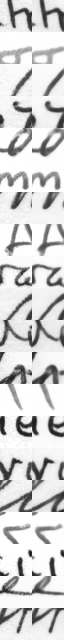

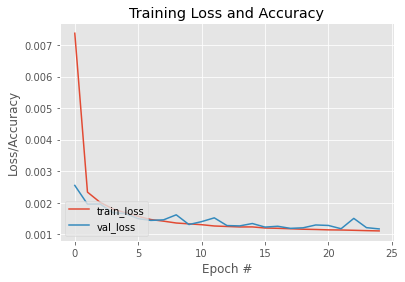

In [147]:
autoencoder = Autoencoder_train(configuration)
autoencoder.train_network()

In [148]:
new_cluster_centers(images[:nb_images_treat],
                    model_path=BASE_FOLDER+configuration["model_path"],
                    path_to_save=BASE_FOLDER+configuration["path_cluster_centers"], 
                    nb_clusters=configuration["Number_clusters"], 
                    max_no_improvement=configuration["max_no_improvement"],
                    shape_images=configuration["shape_images"]*2,
                    max_key_points=configuration["max_key_points"])

treated 360/3344 key points for this image !
treated 360/4105 key points for this image !
treated 360/1717 key points for this image !
treated 360/4011 key points for this image !
treated 360/3821 key points for this image !
treated 360/1702 key points for this image !
treated 360/7597 key points for this image !
treated 360/10983 key points for this image !
treated 360/4807 key points for this image !
treated 360/2220 key points for this image !
treated 360/3705 key points for this image !
treated 360/5281 key points for this image !
treated 360/4809 key points for this image !
treated 360/5397 key points for this image !
treated 360/4852 key points for this image !
treated 360/5715 key points for this image !
treated 360/3063 key points for this image !
treated 360/6738 key points for this image !
treated 360/5081 key points for this image !
treated 360/4712 key points for this image !
Init 1/3 with method: k-means++
Inertia for init 1/3: 9449005.880705
Init 2/3 with method: k-means+

In [149]:
new_pca_NN_vlad(images=images[:nb_images_treat], 
                path_to_save=BASE_FOLDER+configuration["path_pca_model"], 
                cluster_centers_path=BASE_FOLDER+configuration["path_cluster_centers"], 
                encoder_model_path=BASE_FOLDER+configuration["model_path"], 
                n_components=configuration["pca_number_components"],
                shape_images=configuration["shape_images"]*2,
                max_key_points=configuration["max_key_points"])

treated 360/3344 key points for this image !
treated 360/4105 key points for this image !
treated 360/1717 key points for this image !
treated 360/4011 key points for this image !
treated 360/3821 key points for this image !
treated 360/1702 key points for this image !
treated 360/7597 key points for this image !
treated 360/10983 key points for this image !
treated 360/4807 key points for this image !
treated 360/2220 key points for this image !
treated 360/3705 key points for this image !
treated 360/5281 key points for this image !
treated 360/4809 key points for this image !
treated 360/5397 key points for this image !
treated 360/4852 key points for this image !
treated 360/5715 key points for this image !
treated 360/3063 key points for this image !
treated 360/6738 key points for this image !
treated 360/5081 key points for this image !
treated 360/4712 key points for this image !


#Test Model

In [150]:
import importlib
importlib.reload(Autoencoder)

<module 'Autoencoder' from '/content/drive/My Drive/Colab Notebooks/Writer_identification/Autoencoder.py'>

In [151]:
def test_sift_NN_vlad(images, writers, pca_path, cluster_centers_path, model_path, max_key_points, accuracy_calculator, shape_images):
  
  autoencoder = Autoencoder.Encoder_NN((shape_images, shape_images), max_key_points)
  autoencoder.set_model(model_path=model_path)
  local_features_extractor = Local_features_extractor.Local_feature_exractor(Norms.Norm.No_norm, local_feature_extractor=autoencoder)

  clusters_centers = Clusterer.Clusterer.fit_ancient_data(cluster_centers_path)
  pca_instance = PCA_reduction.PCA_reduction(pca_path)
  vlad = Global_feature_exractors.VLAD(clusters_centers, pca_instance=pca_instance)

  images_pre = [Image.Image(path_image, local_features_extractor, global_feature_extractor=vlad) for path_image in images]

  cosine_distance = Distances.Distance.cosine_distance
  accuracy_value = accuracy_calculator(images_pre, writers, vlad, cosine_distance)

  return accuracy_value

In [152]:
writers, images = load_dataset_all(WORK_DIR)
X_test, y_test = get_test_sample(images, writers, configuration["test_sample_size"])

In [153]:
accuracy_value = test_sift_NN_vlad(images=X_test,
                                    writers=y_test,
                                    pca_path=BASE_FOLDER+configuration["path_pca_model"],
                                    cluster_centers_path=BASE_FOLDER+configuration["path_cluster_centers"],
                                    model_path=BASE_FOLDER+configuration["model_path"],
                                    max_key_points=configuration["max_key_points"],
                                    accuracy_calculator=accuracy,
                                    shape_images=configuration["shape_images"]*2)

print()
print("Accuracy value for", training_object," :",accuracy_value*100,"%")

treated 360/4041 key points for this image !
treated 360/13466 key points for this image !
treated 360/2520 key points for this image !
treated 360/3236 key points for this image !
treated 360/2948 key points for this image !
treated 360/5519 key points for this image !
treated 360/8375 key points for this image !
treated 360/3513 key points for this image !
treated 360/8099 key points for this image !
treated 360/3581 key points for this image !
treated 360/7614 key points for this image !
treated 360/7036 key points for this image !
treated 360/6034 key points for this image !
treated 360/5408 key points for this image !
treated 360/4856 key points for this image !
treated 360/14303 key points for this image !
treated 360/3089 key points for this image !
treated 360/7526 key points for this image !
treated 360/5971 key points for this image !
treated 360/5305 key points for this image !
IAM_294  ==>  IAM_294 ( g07-000a , g07-007a )
IAM_289  ==>  IAM_289 ( f07-032b , f07-036 )
ICDAR_0